## Exercises - Linear Regression

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Exercise 0 - Simulate phone dataset 

We want to simulate data $(x,y)$ to represent cost for phone subscriptions, with: 

- $x$ - called minutes per month
- $y$ - SEK per month 

&nbsp; a) Use ```numpy.random.normal()``` to simulate a dataset with the following requirements:(*)
- set a seed to 42 (for reproducibility and reference)
- simulate 400 x-values from the r.v. $X \sim \mathcal{N}(100, 100)$ 
- take absolute value of these x-values
- simulate noise 400 noise values from r.v. $\epsilon \sim \mathcal{N(0, 50)}$ 
- Let $y = 2x+25+\epsilon$
- plot the data set 

In [2]:
#Simulate data
np.random.seed(42)
phone_data_x = np.abs(np.random.normal(loc=100, scale=100, size=(400))) #Simulate 400 normally distributed data points with mean = 100 and SD = 100 
phone_data_error = np.random.normal(loc=0, scale=50, size=(400)) #Simulate 400 normally distributed "error" datapoints with mean = 0 and SD är 50
phone_data_y = 25 + 2 * phone_data_x + phone_data_error

#Create a dataframe
phone_data = pd.DataFrame({"Called Minutes": phone_data_x, "Price": phone_data_y})
phone_data.head()

,Called Minutes,Price
0,149.671415,244.621448
1,86.173570,167.378389
2,164.768854,354.799893
3,252.302986,531.955001
4,76.584663,155.666051


In [3]:
def plot_phone_data(data:pd.DataFrame, title:str, ground_truth=False) -> None:

    fig, ax = plt.subplots(dpi=100)

    sns.scatterplot(data = data, x = "Called Minutes", y = "Price")
    _ = ax.set(xlabel="Called Minutes per Month", ylabel="SEK per Month", title=title)

    if ground_truth:
        line_y = 25 + 2 * data["Called Minutes"]
        _ = sns.lineplot(x=data["Called Minutes"], y=line_y, color="red")
        _ = ax.legend(labels=["Training data", "Ground truth"])      

    plt.show()

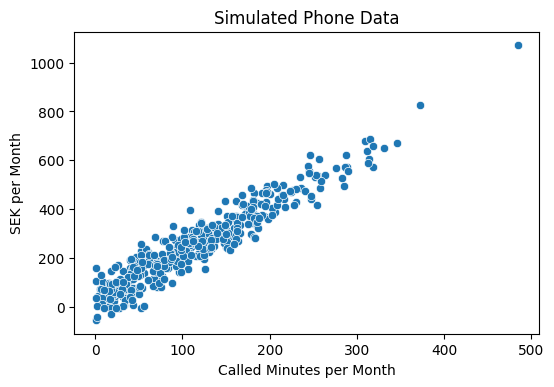

In [4]:
plot_phone_data(phone_data, "Simulated Phone Data")

b) Now we want to remove some outliers according to this assumption: (*)
- no one talks more than 300 min using this type of subscription
- no ones costs can be negative
- plot the new dataset
- also plot ground truth using the true parameters $\beta_0 = 25, \beta_1 = 2$

c) Insert the values into a DataFrame (*)

In [5]:
#Check for outliers in the predictor (x > 300)
phone_data[phone_data["Called Minutes"] > 300].count()

Called Minutes    11
Price             11
dtype: int64

In [6]:
#Check for outliers in the response variable (x < 0)
phone_data[phone_data["Price"] < 0].count()

Called Minutes    8
Price             8
dtype: int64

In [7]:
#Remove the outliers 
phone_data_outliers_rem = phone_data[(phone_data["Called Minutes"] <= 300) & (phone_data["Price"] >= 0)]
len(phone_data_outliers_rem)

381

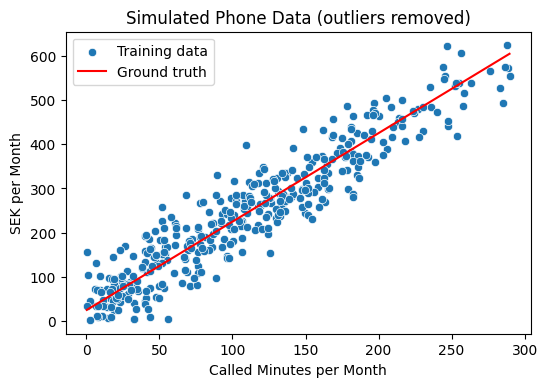

In [8]:
plot_phone_data(phone_data_outliers_rem, ground_truth=True, title="Simulated Phone Data (outliers removed)")

### Exercise 1 - Train|test split 

Before moving on with linear regression we shall first perform a train-test-split. 

&nbsp; a) Create a train-test-split function with the following call signature: (*)

```py
def train_test_split(X: pd.DataFrame, y: pd.DataFrame, train_fraction=.7: float, random_state=42: int, replace=False: bool) -> tuple
```

that returns the tuple:
```
(X_train, X_test, y_train, y_test)
```


In [9]:
def train_test_split(X:pd.DataFrame, y:pd.DataFrame, train_fraction:float=.7, random_state:int=42, replace:bool=False) -> tuple:
    """
    Splits two dataframes (X and y) at the specified fraction.
    Random state is set to a specific seed, so that both the X and y data contains the same indexes. 
    """

    train_fraction = int(len(X) * train_fraction) 

    X_train = X.sample(n=train_fraction, random_state=random_state, replace=replace) #random_state is the seed (so we will get the same numbers for both X and y)
    X_test = X.drop(X_train.index) #Drop all of the indexes that are in the X_train data
    
    y_train = y.sample(n=train_fraction, random_state=random_state, replace=replace)
    y_test = y.drop(y_train.index) #Drop all of the indexes that are in the y_train data
    
    return X_train, X_test, y_train, y_test

b) Now use this to split up your data into a training set and test set. Check manually that the split is performed correctly. (*)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(phone_data_outliers_rem["Called Minutes"], phone_data_outliers_rem["Price"])

In [11]:
X_train.head()

277     39.978312
196     11.614256
46      53.936123
55     193.128012
57      69.078762
Name: Called Minutes, dtype: float64

In [12]:
y_train.head() #The indexes matches for the first five observations

277    192.570147
196     34.734766
46     151.202158
55     371.612382
57     111.395409
Name: Price, dtype: float64

In [13]:
#Checking so there are no matching indexes
print(X_test.index.isin(X_train.index).sum())
print(y_test.index.isin(y_train.index).sum())

0
0


In [14]:
print(len(X_train))
print(len(y_train)) #Same length as X_train

print(len(X_test))
print(len(y_test)) #Same length as X_test

print(len(phone_data_outliers_rem))
print(len(X_train) + len(X_test)) #Same length as the full dataset
print(len(y_train) + len(y_test)) #Same length as the full dataset

266
266
115
115
381
381
381


### Exercise 2 - Simple linear regression with normal equation

Use the normal equation for simple linear regression to solve for the coefficients $\hat{\beta} = (\beta_0, \beta_1)$. Note that you should only use the training data to fit the regression line, and not data from the test set. Plot the the regression line, together with ground truth and training data. 

In [15]:
def prediction_model(x_value:float):
    """
    Calculates the intercept and the slope, 
    and returns the predicted y-value.
    """

    beta_1, beta_0 = np.polyfit(X_train, y_train, deg = 1) #degree 1 is simple linear regression
    predicted_value = beta_0 + beta_1 * x_value
    
    return predicted_value

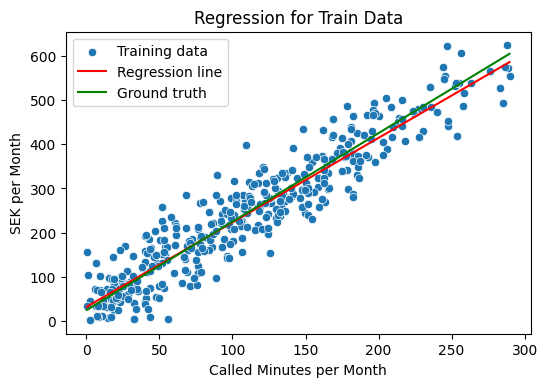

In [16]:
#Creating the lines
regression_line = [prediction_model(data_point) for data_point in X_train] #Calculates the regression line
ground_truth_line = 25 + 2 * X_train #Calculates the ground truth

#Plotting the data
fig, ax = plt.subplots(dpi=100)
sns.scatterplot(data = phone_data_outliers_rem, x = "Called Minutes", y = "Price")
_ = ax.set(xlabel="Called Minutes per Month", ylabel="SEK per Month", title="Regression for Train Data")
_ = sns.lineplot(x=X_train, y=regression_line, color="red")
_ = sns.lineplot(x=X_train, y=ground_truth_line, color="green")
_ = ax.legend(labels=["Training data", "Regression line", "Ground truth"])

### Exercise 3 - Prediction and evaluation

a) Use your model to make prediction on testing data. Plot the prediction cost against X_test, and y_test against X_test. (*)

In [17]:
# Make predictions for the test data 
predicted_price = [prediction_model(data_point) for data_point in X_test]

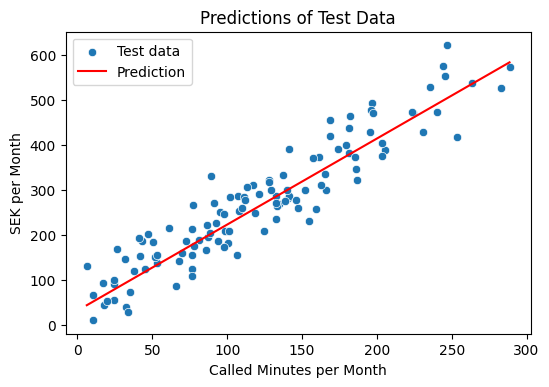

In [18]:
#Plotting the data
fig, ax = plt.subplots(dpi=100)

sns.scatterplot(x=X_test, y=y_test)
_ = ax.set(xlabel="Called Minutes per Month", ylabel="SEK per Month", title="Predictions of Test Data")
_ = sns.lineplot(x=X_test, y=predicted_price, color="red")
_ = ax.legend(labels=["Test data", "Prediction"])

In [19]:
#Create a dataframe of the real y-values and the predicted y-values
real_and_predictions = pd.DataFrame({"Real value":y_test, "Predicted value":predicted_price})
real_and_predictions.head()

,Real value,Predicted value
1,167.378389,196.856592
4,155.666051,178.536928
8,137.119904,133.578710
13,271.539890,206.704208
14,186.599267,170.717458


b) Calculate MAE, MSE, RMSE (*)

In [20]:
MAE = 1 / len(real_and_predictions) * np.sum(np.abs(real_and_predictions["Real value"] - real_and_predictions["Predicted value"]))
MSE = 1 / len(real_and_predictions) * np.sum((real_and_predictions["Real value"] - real_and_predictions["Predicted value"]) ** 2)
RMSE = np.sqrt(MSE)

print(f"Mean absolute error on testing data: {MAE:.2f} SEK.")
print(f"Mean squared error on testing data: {MSE:.2f}.")    
print(f"Root mean squared error on testing data: {RMSE:.2f} SEK.")    

Mean absolute error on testing data: 40.12 SEK.
Mean squared error on testing data: 2401.58.
Root mean squared error on testing data: 49.01 SEK.


### Exercise 4 - Simulate more explanatory variables 

Now we will simulate the explanatory variables for minutes, text messages and amount of surf. For reference and reproducibility use numpy random seed 42. Assume there is:

- mean start cost: 25kr
- mean cost per minute: 2kr
- mean cost per sms: 50 öre
- mean cost per GB: 50kr

Then the model for the cost will be:
$y = 25 + 2x_1 + 0.5x_2 + 50x_3 + \epsilon$, where

- $x_i$ sampled from r.v. $X_i$ for $i = \{1,2,3\}$
- $X_1 \sim |\mathcal{N}(100,100)|$, (absolute value)
- $X_2 \sim \mathcal{U}(0,50)$, (discrete uniform distribution)
- $X_3 \sim |\mathcal{N}(0,2)|$,
- $\epsilon \sim \mathcal{N}(0,50)$

&nbsp; a) Simulate 10000 samples of each of $x_1, x_2, x_3$ and $y$ and save them in a DataFrame. Also add an intercept column containing ones. (\*)

In [21]:
#Simulate normally distributed data points  
def simulate_data(size):
    """
    Simulates data for minutes of calls, number of sms and used GB.
    Adds an intercept column containing ones (to be multiplied with beta 0 / intercept value.)
    Adds an error term and calculates the total cost.
    Returns a dataframe with all values.
    """
    
    np.random.seed(42)
    x1_minutes_of_calls = np.abs(np.random.normal(loc=100, scale=100, size=(size)))
    x2_number_of_sms = np.random.randint(low=0, high=51, size=(size))
    x3_used_GB = np.abs(np.random.normal(loc=0, scale=2, size=(size)))
    error = np.random.normal(loc=0, scale=50, size=(size))
    y_total_cost = 25 + (2 * x1_minutes_of_calls) + (0.5 * x2_number_of_sms) + (50 * x3_used_GB) + error

    phone_data = pd.DataFrame({"Intercept" : np.ones(size),
                                "Minutes of calls" : x1_minutes_of_calls, 
                                "Number of sms" : x2_number_of_sms, 
                                "Used GB" : x3_used_GB,
                                "Total cost": y_total_cost
                                })

    return phone_data

In [22]:
#Sumulate the data for a sample size of 10000
phone_data_mult = simulate_data(10000)
phone_data_mult.head()

,Intercept,Minutes of calls,Number of sms,Used GB,Total cost
0,1.0,149.671415,41,2.208350,494.352864
1,1.0,86.173570,16,1.026793,329.453255
2,1.0,164.768854,30,0.412271,458.010458
3,1.0,252.302986,33,0.004223,527.052669
4,1.0,76.584663,37,1.496144,323.298123


b) Make histograms for each of the explanatory variables $x_1, x_2, x_3$ and the response variable $y$ (\*)

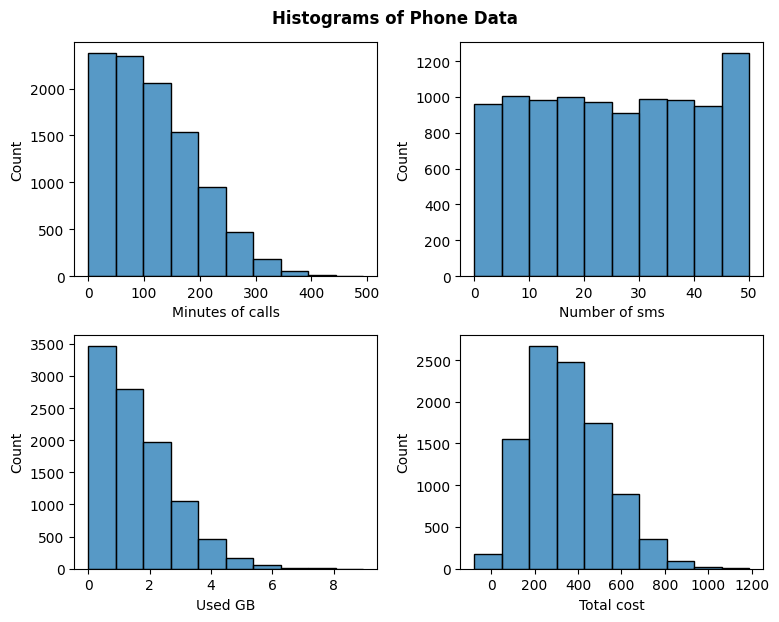

In [23]:
#Plotting the data

fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=100)

for ax, feature in zip(axes.flatten(), phone_data_mult.columns[1:5]):
  sns.histplot(data = phone_data_mult[feature], bins=10, ax = ax)

fig.tight_layout()
_ = fig.suptitle("Histograms of Phone Data", y=1.03, fontweight="bold")


c) Clean the data using the following constraints (\*)

- surf should be less than 4
- minutes should be less than 300
- cost should be larger than 0

In [24]:
def remove_outliers(data):
    """
    Removes all outliers from the data and returns the dataset.
    """

    data = data[(data["Minutes of calls"] < 300) & 
                (data["Used GB"] < 4) &
                (data["Total cost"] > 0)]

    return data

In [25]:
#Creating new dataset without outliers
phone_data_mult_outliers_rem = remove_outliers(phone_data_mult)
len(phone_data_mult_outliers_rem)

9321

d) Make new histograms for the variables. (\*)

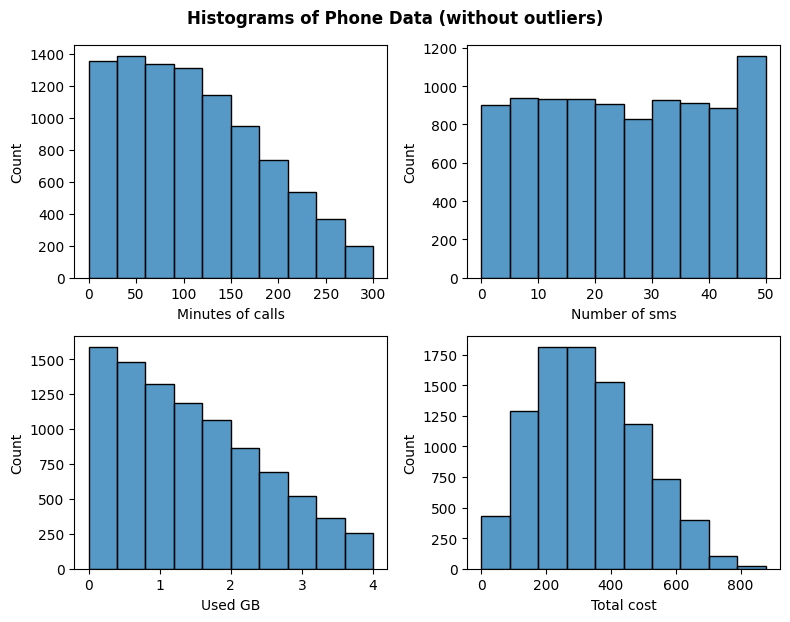

In [26]:
#Plotting the data

fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=100)

for ax, feature in zip(axes.flatten(), phone_data_mult_outliers_rem.columns[1:5]):
  sns.histplot(data = phone_data_mult_outliers_rem[feature], bins=10, ax = ax)

fig.tight_layout()
_ = fig.suptitle("Histograms of Phone Data (without outliers)", y=1.03, fontweight="bold")

### Exercise 5 - Multiple linear regression 

a) Perform a train|test split with 0.8 of the data for training. (*)

In [45]:
def train_test_split_for_dataframe(data:pd.DataFrame, train_fraction:float=.8, random_state:int=42, replace:bool=False) -> tuple:
    """
    Splits a dataframe into training and testing data, 
    and separates the X and y data from each other. 
    Returns the dataframe.
    """

    train_fraction = int(len(data) * train_fraction)

    train_data = data.sample(n=train_fraction, random_state=random_state, replace=replace)
    test_data = data.drop(train_data.index) #Drop all of the indexes that are in the X_train data

    train_data_X, train_data_y  = train_data.drop("Total cost", axis="columns"), pd.DataFrame({"Total cost":train_data["Total cost"]})
    test_data_X, test_data_y  = test_data.drop("Total cost", axis="columns"), pd.DataFrame({"Total cost":test_data["Total cost"]})
    
    return train_data_X, train_data_y, test_data_X, test_data_y

In [46]:
#Splitting the data into training and testing
train_data_X, train_data_y, test_data_X, test_data_y = train_test_split_for_dataframe(phone_data_mult_outliers_rem)

In [47]:
print(len(train_data_X))
print(len(train_data_y)) #Same length as X_train

print(len(test_data_X))
print(len(test_data_y)) #Same length as X_test

print(len(phone_data_mult_outliers_rem))
print(len(train_data_X) + len(test_data_X)) #Same length as the full dataset
print(len(train_data_y) + len(test_data_y)) #Same length as the full dataset

7456
7456
1865
1865
9321
9321
9321


In [48]:
#Checking so there are no matching indexes
print(train_data_X.index.isin(test_data_X.index).sum())
print(train_data_y.index.isin(test_data_y.index).sum())

0
0


b) Use the normal equation to compute $\hat{\beta}$ (*)

In [49]:
def regression_fit(X, y):
    """
    Calculates the beta hat values to use in the prediction model.
    """
    
    beta_hat = np.linalg.pinv(X.T @ X) @ X.T @ y # @ means matrix multiplication 
    
    return beta_hat

In [50]:
#Calculates beta hat
beta_hat = regression_fit(train_data_X, train_data_y)
print(beta_hat)

   Total cost
0   26.142516
1    1.994415
2    0.439784
3   50.391537


In [51]:
def price_prediction(train_data_X, train_data_y, x_for_prediction):
    """
    Predicts the y-values by calculating the dot product between the x values and beta hat. 
    """

    beta_hat = regression_fit(train_data_X, train_data_y)
    prediction = np.dot(x_for_prediction, beta_hat)

    return prediction

In [34]:
#The code below gives the same results as above
"""def prediction_using_beta_hat(data_X, beta_hat):
    data_X = data_X.to_numpy()
    beta_hat = beta_hat.to_numpy().reshape(4,1)
    
    predictions = data_X @ beta_hat
    return predictions"""

'def prediction_using_beta_hat(data_X, beta_hat):\n    data_X = data_X.to_numpy()\n    beta_hat = beta_hat.to_numpy().reshape(4,1)\n    \n    predictions = data_X @ beta_hat\n    return predictions'

c) Predict on the test data and compute MAE, MSE and RMSE. (*)

In [52]:
#Predicts the prices for the test data
predictions_mult_reg = price_prediction(train_data_X, train_data_y, test_data_X)
predictions_mult_reg

array([[256.78660964],
       [388.72845459],
       [270.54909634],
       ...,
       [383.05835615],
       [535.02438291],
       [168.67939147]])

In [53]:
#Saves the predicted and real values in a dataframe
predicted_and_real_mult = pd.DataFrame(predictions_mult_reg, columns=["Predicted value"])
predicted_and_real_mult = predicted_and_real_mult.join(test_data_y.reset_index(drop=True))
predicted_and_real_mult = predicted_and_real_mult.rename(columns={"Total cost":"Real value"})
predicted_and_real_mult

,Predicted value,Real value
0,256.786610,329.453255
1,388.728455,458.010458
2,270.549096,323.298123
3,202.202967,216.036377
4,477.407156,499.872433
...,...,...
1860,207.476435,163.325176
1861,192.421097,127.400065
1862,383.058356,378.445022
1863,535.024383,534.323522


In [59]:
#Manually checking so that the dot product work
predicted_price_first_obs = 0
for i in range(len(beta_hat)):
    predicted_price_first_obs += test_data_X.iloc[0,i] * beta_hat.iloc[i,0]
print(predicted_price_first_obs) #This result in the same predicted value as above

256.78660964491087


In [41]:
#Calculating MAE, MSE and RMSE
MAE_mult = 1 / len(predicted_and_real_mult) * np.sum(np.abs(predicted_and_real_mult["Real value"] - predicted_and_real_mult["Predicted value"]))
MSE_mult = 1 / len(predicted_and_real_mult) * np.sum((predicted_and_real_mult["Real value"] - predicted_and_real_mult["Predicted value"]) ** 2)
RMSE_mult = np.sqrt(MSE)

print(f"Mean absolute error on testing data: {MAE_mult:.2f} SEK.")
print(f"Mean squared error on testing data: {MSE_mult:.2f}.")    
print(f"Root mean squared error on testing data: {RMSE_mult:.2f} SEK.")  

Mean absolute error on testing data: 39.30 SEK.
Mean squared error on testing data: 2404.74.
Root mean squared error on testing data: 49.01 SEK.


d) Now repeat 4a), 4c), 5a), 5b) using 10, 100, 1000, 10000, 100000, 1000000 samples, and calculate RMSE for each of these simulations. Plot the RMSE against sample size. (**)

In [42]:
sample_size = [10, 100, 1000, 10000, 100000, 1000000]
RMSE_for_sample = []

for sample in sample_size:

    #Creating data and removing outliers
    phone_data_mult = simulate_data(sample)
    phone_data_mult = remove_outliers(phone_data_mult)

    #Splitting the data into train and test
    train_data_X, train_data_y, test_data_X, test_data_y = train_test_split_for_dataframe(phone_data_mult)

    #Predicting the y-values for the test data
    predictions_mult_reg = price_prediction(train_data_X, train_data_y, test_data_X)

    #Saving the real values and predicted values in a dataframe
    predicted_and_real_mult = pd.DataFrame(predictions_mult_reg, columns=["Predicted value"])
    predicted_and_real_mult = predicted_and_real_mult.join(test_data_y.reset_index(drop=True)) #train data
    predicted_and_real_mult = predicted_and_real_mult.rename(columns={"Total cost":"Real value"})

    #Calculating RMSE and saving it in a list
    MSE_mult = 1 / len(predicted_and_real_mult) * np.sum((predicted_and_real_mult["Real value"] - predicted_and_real_mult["Predicted value"]) ** 2)
    RMSE_mult = np.sqrt(MSE_mult)
    RMSE_for_sample.append(RMSE_mult)

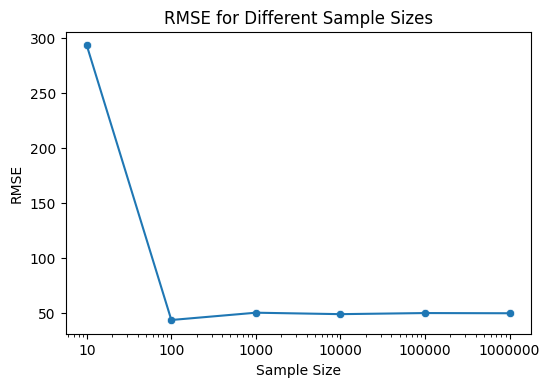

In [43]:
#Plotting the data

fig, ax = plt.subplots(dpi=100)

sns.scatterplot(x=sample_size, y=RMSE_for_sample)
_ = ax.set(xlabel="Sample Size", ylabel="RMSE", title="RMSE for Different Sample Sizes")
_ = sns.lineplot(x=sample_size, y=RMSE_for_sample, color="#1f77b4")
ax.set_xscale('log')
_ = ax.set_xticks(ticks=[10, 100, 1000, 10000, 100000, 1000000], labels=[10, 100, 1000, 10000, 100000, 1000000])